In [1]:
from PIL import Image
import torch.utils.data as data
import arrow
import sys
import os
import os.path
import time
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as func
from torch.utils.data import DataLoader
import h5py


In [2]:
class Ucsd_loader():
    def __init__(self,dir,given,predict,total):
        
        self.data_list = []
        for root, dir, files in os.walk(dir):
            for file in files:
                if file.find('.h5')!= -1:
                    self.data_list.append(os.path.join(root, file))
        self.data_list.sort()

        self.seq_length = given + predict
        self.given = given
        self.predict = predict
        self.total = total
        self.num_frames = 200

        
        self.all_list = []
        
        for j in range(int(self.total/self.num_frames)):
            idx = j * self.num_frames
            for i in range(idx, idx + self.num_frames - (self.seq_length - 1)):
                pre = self.data_list[i]
                nex = self.data_list[i + (self.seq_length - 1)]

                a = pre.split('/')
                b = nex.split('/')

                a_frame = a[-1].split('_')[-1][1:-3]

                b_frame = b[-1].split('_')[-1][1:-3]

                self.all_list.append(self.data_list[i:i+self.seq_length])

        print("size of the data: ", len(self.all_list))

    def __getitem__(self, index):
        
        path = self.all_list[index]
        data = []
        label = []
        for i in range(len(path)):
            gt_file = h5py.File(path[i],'r')
            datai = np.asarray(gt_file['density'])
            
            if i < self.given:
                data.append(datai)
            else:
                label.append(datai)

#         data = np.asarray(data)
#         label = np.asarray(label)
    
        data = np.float32(data)
        label = np.float32(label)

        return data, label

    def __len__(self):
        return len(self.all_list)


In [3]:
class Dataloader0():
    def __init__(self,dir,give,predict,rot= True):
        
        self.rot = rot
        self.data_list = []
        for root, dir, files in os.walk(dir):
            for file in files:
                if file.find('.png')!= -1:
                    self.data_list.append(os.path.join(root, file))
        self.data_list.sort()

        self.seq_length = give + predict
        self.give = give
        self.predict = predict
        self.img_size = 256

        self.all_list = []
        for i in range(len(self.data_list) - (self.seq_length - 1)):
            pre = self.data_list[i]
            nex = self.data_list[i+(self.seq_length - 1)]

            a = pre.split('/')
            b = nex.split('/')

            a_UTC = a[-1][:-4]
            b_UTC = b[-1][:-4]

            a_UTC = arrow.get(a_UTC,'MMDDHHmm')
            a_unix = int(a_UTC.timestamp)
            b_UTC = arrow.get(b_UTC,'MMDDHHmm')
            b_unix = int(b_UTC.timestamp)
            
            # just checking whether the given image is within the same day & sequential
            # 6 * 60 because the image was taken every 6 minutes (6 * 60)
            # for this case, we just want to change the if case using scene/frame based 
            if b_unix - a_unix > (self.seq_length-2)*6*60 and b_unix - a_unix < self.seq_length*6*60:
                self.all_list.append(self.data_list[i:i+self.seq_length])

        print(len(self.all_list))

    def __getitem__(self, index):
        
        path = self.all_list[index]
        data = []
        label = []
        for i in range(len(path)):
            datai = Image.open(path[i]).resize((self.img_size, self.img_size),Image.BILINEAR)
            datai = np.asarray(datai)
            if i < self.give:
                data.append(datai)
            else:
                label.append(datai)

        data = np.asarray(data)
        label = np.asarray(label)
        if self.rot:
            random = int(3.999999*np.random.random())
            data = np.float32(np.rot90(data, random,axes = (1,2)))
            label = np.float32(np.rot90(label, random,axes = (1,2)))
        else:
            data = np.float32(data)
            label = np.float32(label)

        return data, label

    def __len__(self):
        return len(self.all_list)


In [4]:
class Ucsd_loader1():
    def __init__(self, img_dir, target_dir, num_frames):
        
        self.data_list = []
        for root, dir, files in os.walk(img_dir):
            for file in files:
                if file.find('.png')!= -1:
                    self.data_list.append(os.path.join(root, file))
        self.data_list.sort()
        
        self.gt_list = []
        for root, dir, files in os.walk(target_dir):
            for file in files:
                if file.find('.h5')!= -1:
                    self.gt_list.append(os.path.join(root, file))
        self.gt_list.sort()

        self.seq_length = num_frames
        self.img_size = 256
        
        self.all_dlist = []
        self.all_glist = []
  
        for i in range(len(self.data_list) - (self.seq_length - 1)):
            self.all_dlist.append(self.data_list[i:i+self.seq_length])
           
            self.all_glist.append(self.gt_list[i:i+self.seq_length])

        print("size of the data: ", len(self.all_dlist), len(self.all_glist))

    def __getitem__(self, index):
        data = []
        label = []
#         print(self.all_glist[index])
#         print(self.all_dlist[index])
        for i in range(len(self.all_glist[index])):
            gt_file = h5py.File(self.all_glist[index][i],'r')
            labeli = np.float32(np.asarray(gt_file['density']))
            labeli = Image.fromarray(labeli).resize((self.img_size,self.img_size),Image.BILINEAR)
            label.append(np.asarray(labeli))
            

            datai = Image.open(self.all_dlist[index][i]).resize((self.img_size, self.img_size),Image.BILINEAR)
            datai = np.asarray(datai)
            data.append(datai)
        
        data = np.float32(data)
        label = np.float32(label)
        return data, label

    def __len__(self):
        return len(self.all_glist)


In [5]:
dataloader0 = Ucsd_loader1('data/train/','data/train_gt',15)
# dataloader0 = Dataloader0('data/trainset/',5,15, 800)
data,label = dataloader0.__getitem__(0)
print(label.shape)

size of the data:  786 786
(15, 256, 256)


(256, 256)


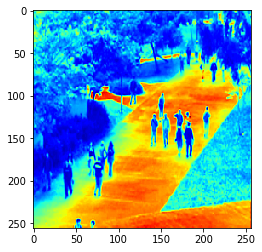

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm as CM
print(data[0].shape)
plt.imshow(data[0], cmap=CM.jet)

In [7]:
from torch.utils.data import DataLoader

self_built_dataset = Ucsd_loader1('data/train/', 'data/train_gt',40)
print(len(self_built_dataset))
trainloader = DataLoader(
    self_built_dataset,
    batch_size=2,
    num_workers=4)


size of the data:  761 761
761


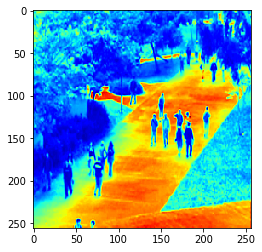

In [8]:
from torch.autograd import Variable
import torchvision
for iteration, data in enumerate(trainloader):
    X, Y = data
#     X = Variable(X, requires_grad=False).cuda()
#     X = X[0][-1].data.cpu().numpy()
    print()
#     img = X[0][0]
#     print(np.sum(img.numpy()))
#     Y = Y[0][0].numpy()
    
#     test = Image.fromarray(Y)
    plt.imshow(X[0][0], cmap=CM.jet)
    break

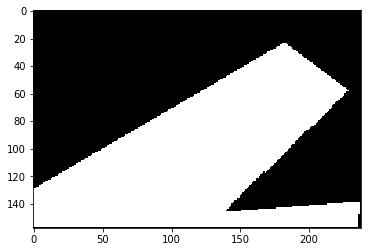

In [9]:
load = np.loadtxt('data/ucsd_mask.txt')
datai = Image.fromarray(load)
plt.imshow(datai)

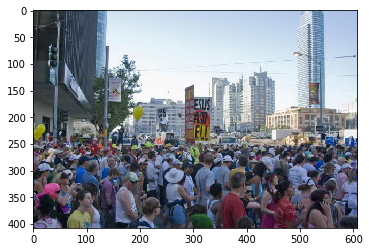

In [13]:
# datai = Image.open('/home/data/urop2018/sfuab/crowdcount-mcnn/output/density_maps_mcnn_shtechB_110/output_IMG_9.png')
datai = Image.open('/home/data/urop2018/sfuab/crowdcount-mcnn/data/formatted_trainval/shanghaitech_part_A_patches_1/train/9.jpg')
plt.imshow(datai)